# Time series forecasting using recurrent neural networks
### Import necessary libraries

In [1]:
%matplotlib notebook

import numpy
import pandas
import math
import time
import sys
import datetime
import psycopg2
import matplotlib.pyplot as ma
import keras.models as km
import keras.layers as kl
import sklearn.preprocessing as sp

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


### Initialize random seed for constant neural network initialization

In [2]:
numpy.random.seed(42)

### Connect to the database and obtain necessary table.

In [3]:
try:
    db_conn = psycopg2.connect(dbname="itoaapm_2018_06_05", user="itoa", host="localhost", password="itoaapm")
except:
    print("I am unable to connect to DB")

ts = pandas.read_sql("""SELECT * FROM data.app_12_apmi_5m""", db_conn)
ts.index = ts['ts']
# delete unnecessary columns
del ts['id']
del ts['ts']
del ts['l1']
del ts['l2']
del ts['l3']
del ts['l4']
del ts['apmi']
# print table info
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8829 entries, 2018-06-15 10:40:00 to 2018-07-16 13:40:00
Data columns (total 1 columns):
cnt    8829 non-null int64
dtypes: int64(1)
memory usage: 138.0 KB


### Get values from specified range

In [4]:
ts = ts['2018-06-16':'2018-07-15']

### Remove possible zero and NA values (by interpolation)
We are using MAPE formula for counting the final score, so there cannot occure any zero values in the time series. Replace them with NA values. NA values are later explicitely removed by linear interpolation.

In [5]:
def print_values_stats():
    print("Zero Values:\n",sum([(1 if x == 0 else 0) for x in ts.values]),"\n\nMissing Values:\n",ts.isnull().sum(),"\n\nFilled in Values:\n",ts.notnull().sum(), "\n")

idx = pandas.date_range(ts.index.min(), ts.index.max(), freq="5min")
ts = ts.reindex(idx, fill_value=None)
print("Before interpolation:\n")
print_values_stats()
ts = ts.replace(0, numpy.nan)
ts = ts.interpolate(limit_direction="both")
print("After interpolation:\n")
print_values_stats()

Before interpolation:

Zero Values:
 0 

Missing Values:
 cnt    99
dtype: int64 

Filled in Values:
 cnt    8541
dtype: int64 

After interpolation:

Zero Values:
 0 

Missing Values:
 cnt    0
dtype: int64 

Filled in Values:
 cnt    8640
dtype: int64 



### Plot values

<IPython.core.display.Javascript object>


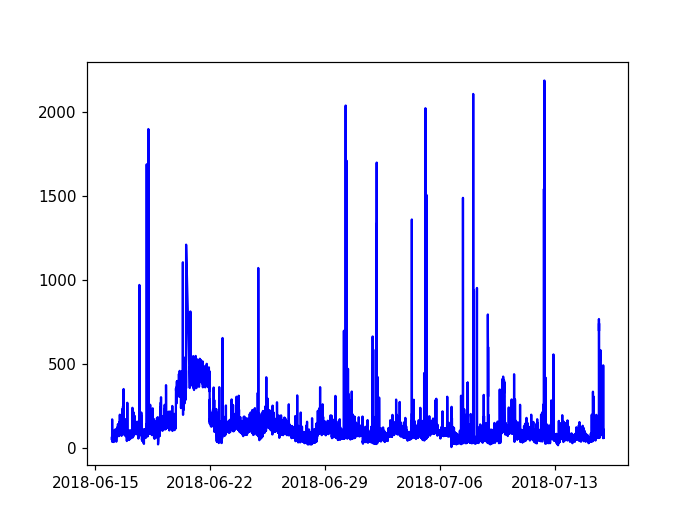

/usr/lib/python3/dist-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [6]:
# Idea: Plot figure now and do not wait on ma.show() at the end of the notebook
def plot_without_waiting(ts_to_plot):
    ma.ion()
    ma.show()
    fig = ma.figure(plot_without_waiting.figure_counter)
    plot_without_waiting.figure_counter += 1
    ma.plot(ts_to_plot, color="blue")
    ma.draw()
    try:
        ma.pause(0.001) # throws NotImplementedError, ignore it
    except:
        pass

plot_without_waiting.figure_counter = 1
plot_without_waiting(ts)

### Normalize time series for neural network
LSTM cells are very sensitive to large scaled values. It's generally better to normalize them into <0,1> interval.

In [7]:
dates = ts.index # save dates for further use
scaler = sp.MinMaxScaler(feature_range=(0,1))
ts = scaler.fit_transform(ts)

### Split time series into train and test series
We have decided to split train and test time series by two weeks.

In [8]:
train_data_length = 12*24*7
ts_train = ts[:train_data_length]
ts_test = ts[train_data_length+1:]

### Create train and test dataset for neural networks
The neural network takes input from TS at time t and returns predicted output at time *t+1*. Generally, we could create neural network that would return predicted output at time *t+n*, just by adjusting *loop_samples* parameter.

In [9]:
def dataset_create(ts, loop_samples):
    x = []
    y = []
    for i in range(len(ts)-loop_samples-1):
        x.append(ts[i:(i+loop_samples), 0])
        y.append(ts[i+loop_samples, 0])
    return numpy.array(x), numpy.array(y)

train_dataset_x, train_dataset_y = dataset_create(ts_train, 1)
test_dataset_x, test_dataset_y = dataset_create(ts_test, 1)

### Reshape datasets for NN into [batch size; timesteps; input dimensionality] format
Keras library have specific needs in case of provided input's format. See https://keras.io/layers/recurrent/ for more details.

In [10]:
def dataset_reshape_for_nn(dataset):
    return dataset.reshape((dataset.shape[0], 1, dataset.shape[1]))

train_dataset_x = dataset_reshape_for_nn(train_dataset_x)
test_dataset_x = dataset_reshape_for_nn(test_dataset_x)

### Create recurrent neural network
This recurrent neural network (RNN) consists of three layers (*input, hidden* and *output*). The input layer is implicitly specified by the hidden layer (*input_shape* parameter). Logically, we need to have exactly one input and one output node for one-step prediction. Number of hidden neurons is specified by *number_lstm_cells* variable.

In this RNN we use LSTM cells with sigmoid (http://mathworld.wolfram.com/SigmoidFunction.html) activation function. Network is configured to use *mean square error* (MSE) as optimalization function that is going to be minimized during backpropagation and *stochastic gradient descend* (SGD) optimizer with default parameters (https://keras.io/optimizers/).

In [11]:
number_lstm_cells = 2
# Layer based network
network = km.Sequential()
# Hidden layer is made from LSTM nodes
network.add(kl.LSTM(number_lstm_cells, activation="sigmoid", input_shape=(1,1)))
# Output layer with one output (one step prediction)
network.add(kl.Dense(1))
network.compile(loss="mse", optimizer="sgd", metrics=['mean_squared_error'])

### Train neural network

Train neural network on train data and plot MSE metrics for each iteration. Results and time of training process depends on *train_iterations* value.

Network fit started...

Network fit finished. Time elapsed:  380.2406704425812 



<IPython.core.display.Javascript object>


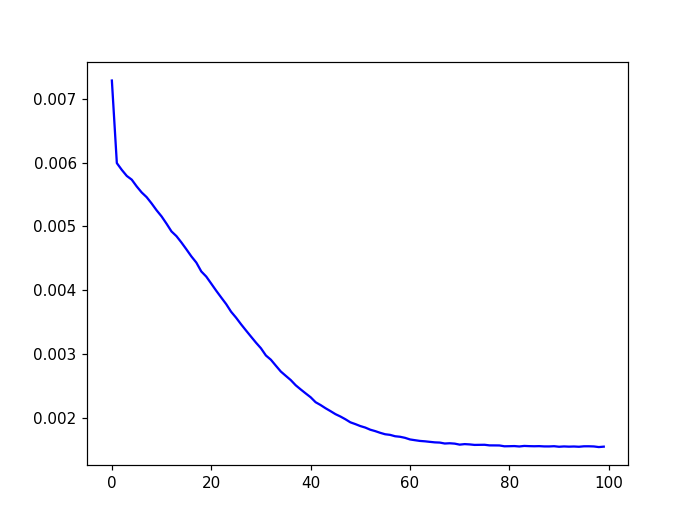

/usr/lib/python3/dist-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [12]:
train_iterations = 100
start_time = time.time()
print("Network fit started...\n")
network_history = network.fit(train_dataset_x, train_dataset_y, epochs=train_iterations, batch_size=1, verbose=0)
print("Network fit finished. Time elapsed: ", time.time() - start_time, "\n")
plot_without_waiting(network_history.history['mean_squared_error'])

### Predict new values
The array *test_dataset_x* is used as an input for the network.

In [13]:
predicted_values_unscaled = network.predict(test_dataset_x)
# Scale the predicted values back using MinMaxScaler
predicted_values_scaled = scaler.inverse_transform(predicted_values_unscaled)
# Scale test values back so we can compare the result
test_values_scaled = scaler.inverse_transform(ts_test)

### Count mean absolute percentage error
We use MAPE (https://www.forecastpro.com/Trends/forecasting101August2011.html) instead of MSE because the result of MAPE does not depend on size of values.

In [14]:
values_sum = 0
for value in zip(test_values_scaled, predicted_values_scaled):
    actual = value[0][0]
    predicted = value[1][0]
    values_sum += abs((actual - predicted) / actual)

values_sum *= 100/len(test_values_scaled)
print("MAPE: ", values_sum, "%\n")

MAPE:  28.076336755737056 %



### Plot predicted values

<IPython.core.display.Javascript object>


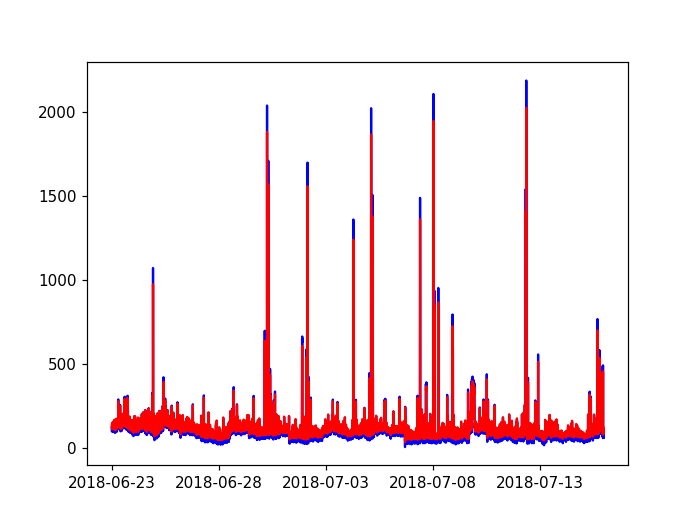

In [15]:
fig = ma.figure(plot_without_waiting.figure_counter)
ma.plot(test_values_scaled, color="blue")
ma.plot(predicted_values_scaled, color="red")
ts_len = len(ts)
date_offset_indices = ts_len // 6
ma.xticks(range(0, ts_len-train_data_length, date_offset_indices), [x.date().strftime('%Y-%m-%d') for x in dates[train_data_length::date_offset_indices]])
fig.show()